# Introduction to Quantum Simulation Algorithms

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2023</i></b><br/> 
        <i> Author：<a href="mailto:antientropy@pku.edu.cn"><b>Shuo Zhou（周烁） 📨 </b></a></i><br/> 
        <i>To execute this document directly, please click the <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">Connect</span> button at the top of <a style="font-weight:bold; color:purple" href="https://bohrium-doc.dp.tech/docs/userguide/Notebook" target="_blank"> Bohrium Notebook</a> Interface.</i><br/>
    </p>
</div>

**Quantum Computing** is a computing model different from classical computers. In the 1970s and 1980s, with the development of quantum mechanics, related research raised the need to observe and simulate quantum systems, and the idea of constructing "quantum computers" that follow quantum mechanics rather than classical physics principles was also born. In 1982, Feynman proposed that using classical computers to simulate the evolution of quantum systems has inherent difficulties, and using "quantum computers" to do these tasks may be a feasible way. In 1985, Deutsch thought about and put forward the concept of a "general-purpose quantum computer" from the point of view of theoretical computers. In 1994, Shor proposed the prime factorisation of large numbers, which is the most important factor of the quantum system. Today, the application of quantum computing to machine learning and NISQ alogrithms has also becom a booming research area.

**Simulating quantum physics** is one of the primary applications of quantum computers[1]. The first explicit quantum simulation algorithm was proposed by Lloyd using product formulas[2], and numerous quantum algorithms for quantum simulations have been extensively developed since then, with various applications ranging from quantum field theory to quantum chemistry and condensed matter physics.

Intuitively, we could classify quantum simulation problems into two catogories: 
- Implementing the time-evolution operator on a given initial state
- Calculating the eigenstate & eigenvalue(energy) of a given Hamiltonian

<img src="https://unsplash.com/photos/CANL3bzp6wU/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjg1NjgyNTEyfA&force=true" style="zoom: 20%">

## 1. Hamiltonian Simulation
  In quantum mechanics, time evolution of the wave function $|\psi(t)\rangle$ is governed by the Schr$\ddot{o}$dinger equation,
  \begin{equation}
    i\hbar\frac{\mathrm{d}}{\mathrm{d}t}|\psi(t)\rangle=H(t)|\psi(t)\rangle
  \end{equation}
  For $H$ independent of time, the solution is:
  \begin{equation}
    |\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle
  \end{equation}
  Many natural Hamiltonians have the form of a sum of terms, common expamles include:
  - A particle in a potential: $H=\frac{p^2}{2m}+V(x)$
  - A $k$-local Heisenberg spin model: $H=-J \sum_{j=1}^N \sigma_j \sigma_{j+1}-h \sum_{j=1}^N \sigma_j$
  
  Here we take Heisenberg model on a $2\times 3$ lattice for numerical example:

In [2]:
import numpy as np
from scipy.linalg import kron, expm, norm
import matplotlib.pyplot as plt

# Pauli Matrices
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])

# System size: two L-length single chains
L = 3

# Construct local Hamiltonians: H1, H2, and H3
H1 = - sum(kron(kron(op, op), np.eye(2**(L+1))) + kron(kron(np.eye(2**L), kron(op, op)), np.eye(2)) for op in [X, Y, Z])
H2 = - sum(kron(kron(np.eye(2),kron(op, op)), np.eye(2**L)) + kron(np.eye(2**(L+1)), kron(op,op)) for op in [X, Y, Z])
H3 = - sum(kron(kron(kron(kron(np.eye(2**i), op), np.eye(2**(L-1))), op), np.eye(2**(L-1-i))) for i in range(0,L) for op in [X, Y, Z])

# Construct total Hamiltonian
H = H1 + H2 + H3

### 1.1 Quantum Circuit: why we need to break Hamiltonian into local terms

In quantum computing, we generally utilize subsets consisting of few single or two-qubit gates to approximate any unitary operation. 

You've probably heard some common gate elements such as **Control-NOT, Rotation-Pauli, Hardamard** and so on. On top of that, we can simulate tensor product of Pauli matrix:

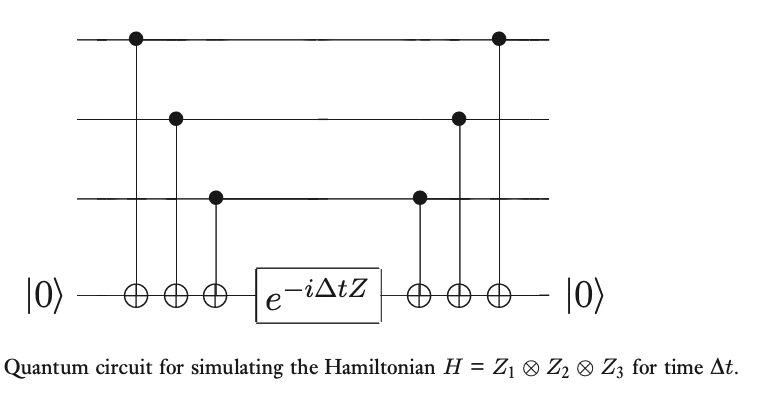

If we could analyse the relationship between original time-evolution operator and unit as above, in principle we could simulate many natural Hamiltonians. In fact, there are following mathematical theorems in a nutshell: 

### 1.2 Product Formula
#### 1.2.1 Lie-Trotter Formula
In Lie algebra, for possibly *noncommutative* operator $X$ and $Y$, the product of their exponential does not behave that simply according to **Baker–Campbell–Hausdorff formula**:
  \begin{gather}
    e^Xe^Y=e^Z\\
    Z=X+Y+\frac{1}{2}[X,Y]+\frac{1}{12}[X,[X,Y]]-\frac{1}{12}[Y,[X,Y]]+\cdots
  \end{gather}
  For *Hamiltonian* with local interactions, $H=\sum_{k=1}^L H_k$, only when $[H_j,H_k]=0$ for all j,k could we split the time-evolution operator as products:
  \begin{equation}
    e^{-iHt}=e^{-iH_1t}e^{-iH_2t}\ldots e^{-iH_Lt}
  \end{equation}
  However, even in general cases where the term do not commute with each other, an enlightening idea is splitting time into segments, called **Lie formula** or **Trotterization**:
  \begin{equation}
    e^{-i(H_1+H_2+\ldots H_L)t}=\lim_{r\rightarrow\infty}(e^{-iH_1t/r}e^{-iH_2t/r}\cdots e^{-iH_L t/r})^r
  \end{equation} 

Here we take Heisenberg model on a $2\times 3$ lattice for numerical example:


In [3]:
# system size: N, local Hamlitonians: H_list
def Lie_Trotter(N, H_list, t_step, r):
    U = np.eye(pow(2,N))
    U_step = np.eye(pow(2,N))
    for H_local in H_list:
        U_step = U_step @ expm(-1j * H_local * t_step)
    for i in range(r):
        U = U @ U_step
    return U

#### 1.2.2 Trotter-Suzuki Formula
  By Taylor's theorem we can calculate the error bounds by straightforward algebra:
  \begin{gather}
    e^{-i(A+B)t}=e^{-iAt}e^{-iBt}+\mathcal{O}(t^2)\\
    e^{-i(A+B)t}=e^{-iAt/2}e^{-iBt}e^{-iAt/2}+\mathcal{O}(t^3)
  \end{gather}
  Generally, for *Hamiltonian* with $L$ terms, one could define recursively:
  \begin{gather}
    S_{1}(t):=e^{-i H_{1} t} e^{-i H_{2} t} \cdots e^{-i H_{L} t}=\prod_{l}^{\longrightarrow} e^{-i H_{l} t},
    S_{2}(t) :=\prod_{l}^{\longrightarrow} e^{-i H_{l} t / 2} \prod_{l}^{\longleftarrow} e^{-i H_{l} t / 2},\\
    S_{2 k}(t):=S_{2 k-2}^2\left(u_k t\right) S_{2 k-2}\left(\left(1-4 u_k\right) t\right) S_{2 k-2}^2\left(u_k t\right)=\prod_{s=1}^{S} \prod_{l=1}^{L} e^{-i t c_{(v, l)} H_{\pi_v(l)}},\\
    u_{k}:=\frac{1}{4-4^{1 /(2 k-1)}},~S=2 \cdot 5^{k-1}.
  \end{gather}
  Thus we have a very significant result called *Trotter Suzuki formula*, p-order expansion satisfies:
  \begin{equation*}
    \|{S_p(t)-e^{-iHt}}\| = \mathcal{O}(t^{p+1}).
  \end{equation*}

In [7]:
# 2-order Trotter-Suzuki Decomposition
def Trotter_Suzuki_2(N, H_list, t_step, r):
    U = np.eye(pow(2,N))
    U_step = np.eye(pow(2,N))
    for H_local in H_list:
        U_step = U_step @ expm(-1j * H_local * t_step / 2)
    for H_local in reversed(H_list):
        U_step = U_step @ expm(-1j * H_local * t_step / 2)
    for i in range(r):
        U = U @ U_step
    return U

In [8]:
# Define p-order Trotter-Suzuki Decomposition by Recursion
def Trotter_Suzuki(N, H_list, t_step, r, p):
    if p == 1:
        return Lie_Trotter(N, H_list, t_step, r)
    elif p == 2:
        return Trotter_Suzuki_2(N, H_list, t_step, r)
    else:
        u = 1/(4-pow(4,1/(p-1)))
        return Trotter_Suzuki(N, H_list, u * t_step, r, p-2) @ Trotter_Suzuki(N, H_list, u * t_step, r, p-2) @ Trotter_Suzuki(N, H_list, (1-4*u) * t_step, r, p-2) @ Trotter_Suzuki(N, H_list, u * t_step, r, p-2) @ Trotter_Suzuki(N, H_list, u * t_step, r, p-2)

If we measure the Trotter Error by spectral norm, let's change the timestep and Trotter number, plot the error using 2-order Trotter-Suzuki formula. We could see that the cubic function fits the error very well, as the theory predicted.

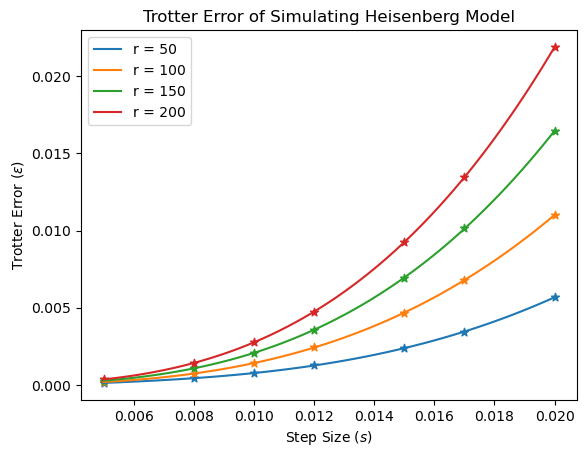

In [9]:
fig,ax = plt.subplots()

# Timestep and Trotter Number
timestep_list = [0.005, 0.008, 0.010, 0.012, 0.015, 0.017, 0.020]
pivot = np.linspace(min(timestep_list), max(timestep_list), 100)
trotter_number_list = [50, 100, 150, 200]

# Plot
for r in trotter_number_list:
    trotter_error = []
    for t_step in timestep_list:
        trotter_error.append(norm(expm(-1j * H * t_step * r) - Trotter_Suzuki_2(2*L, [H1, H2, H3], t_step, r),2))
    coefficients = np.polyfit(timestep_list, trotter_error, 3)
    poly = np.poly1d(coefficients)
    ax.scatter(timestep_list, trotter_error, marker = '*')
    ax.plot(pivot, poly(pivot), label = "r = {r}".format(r = r))

ax.set_title("Trotter Error of Simulating Heisenberg Model")
ax.set_xlabel("Step Size ($s$)")
ax.set_ylabel("Trotter Error ($\epsilon$)")
ax.legend()
plt.show()

### 1.3 qDRIFT Algorithm
Since the permutation of local terms in Trotter-Suzuki Formula is chosen arbitrarily. Without loss of generality, Campbell imported randomness to seek possible improvement[3].

\begin{equation*}
\begin{aligned}
&\begin{aligned}
& \textbf { Input:} \text{ Hamiltonian } H=\sum_{l=1}^L H_l \text { with interaction strength } h_{\Lambda}=\sum_l\left\|H_l\right\| \text {, evolution time } t \text {, } \\
& \text { and number of steps } r \\
& \text { 1: At each time interval } t / r \text { : evolve a random term in Hamiltonian } V_i=e^{-i(t / r) X_i} \text { with } X_i \\
& \quad \text { randomly chosen as } \frac{h_\Lambda}{\left\|H_l\right\|} H_l \text { with probability }\left\|H_l\right\| / h_{\Lambda} \\
& \textbf { Output:} \text{ The unstructured (randomly generated) product formula } V(r)=V_r \ldots V_1
\end{aligned}
\end{aligned}
\end{equation*}

In [10]:
# qDRIFT algorithm
def U_qDRIFT(N, H_list, t, step_number):
    norm_list = []
    for H_l in H_list:
        norm_list.append(norm(H_l, 2))

    total_sum = sum(norm_list)
    
    unitary_list = []
    for index in range(len(H_list)):
        unitary_list.append(expm(-1j * (total_sum / norm_list[index]) * H_list[index] * (t / step_number)))

    probabilities = norm_list/total_sum

# Randomly Generate
    U_qDrift = np.eye(2**(N))
    for i in range(step_number):
        selected_index = np.random.choice(len(probabilities), p = probabilities)
        U_qDrift = U_qDrift @ unitary_list[selected_index]
    return U_qDrift


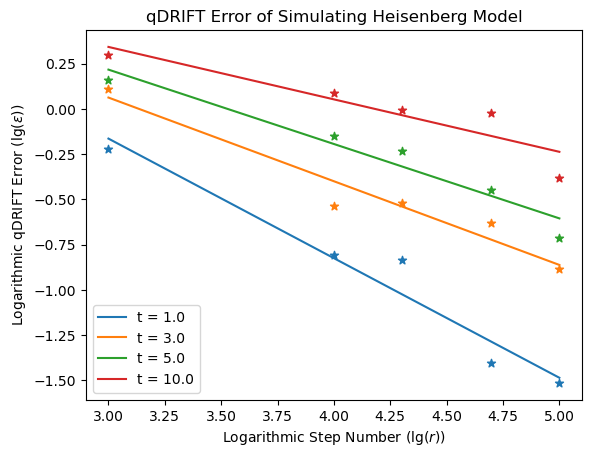

In [12]:
fig,ax = plt.subplots()

# Evolution Time and Random Walk Step Number
step_number_list = [1000, 10000, 20000, 50000, 100000]
pivot = np.linspace(min(np.log(step_number_list)/np.log(10)), max(np.log(step_number_list)/np.log(10)), 100)
t_list = [1.0, 3.0, 5.0, 10.0]

for t in t_list:
    qDRFIT_Error = []
    for step_number in step_number_list:
        qDRFIT_Error.append(norm(expm(-1j * H * t) - U_qDRIFT(2*L, [H1, H2, H3], t, step_number),2))
    coefficients = np.polyfit(np.log(step_number_list)/np.log(10), np.log(qDRFIT_Error)/np.log(10), 1)
    poly = np.poly1d(coefficients)
    ax.scatter(np.log(step_number_list)/np.log(10), np.log(qDRFIT_Error)/np.log(10), marker = '*')
    ax.plot(pivot, poly(pivot), label = "t = {t}".format(t = t))
        
ax.set_title("qDRIFT Error of Simulating Heisenberg Model")
ax.set_xlabel("Logarithmic Step Number ($\lg(r)$)")
ax.set_ylabel("Logarithmic qDRIFT Error ($\lg(\epsilon)$)")
ax.legend()
plt.show()

The slope is almost -1/2, which roughly verify the theory: qDRIFT_Error ~ $\frac{1}{\sqrt{N}}$

  ### 1.4 More About Efficient Simulation
  We say $H$ can be effciently *effeciently simulated* if for any $t>0,\epsilon>0$, there is a quantum circuit $U$
  consisting of poly$(n,t,1/\epsilon)$ gates such that $\Vert U-e^{-iHt}\Vert\leqslant\epsilon$.
  
  Generally, the problem of simulating Hamiltonians is **BQP-hard**.
  
  Up to now, mainstream algorithms for quantum simulation include:
  1. **Product Formula**: the most straightforward approach first proposed. 
  2. **Randomized Product Formula** randomly permuting terms in product formula & the qDRIFT algorithm.
  3. **Truncated Taylor Series**: an alternative approach that leverages *LCU* achieves complexity poly$(1/\epsilon)$.
  4. **Quantum Singnal Processing**: an approach based on qubitization and block-encoding with an optimal complexity tradeoff.

## 2. Variational Quantum Eigensolver

The variational Quantum Eigensolver(VQE)[4] uses the variational principle to compute the ground state energy of a Hamiltonian,
a problem that is central to quantum chemistry and condensed matter physics. Conventional
computing methods are constrained in their accuracy due to the computational limits facing exact
modeling of the exponentially growing electronic wavefunction for these many-electron systems.

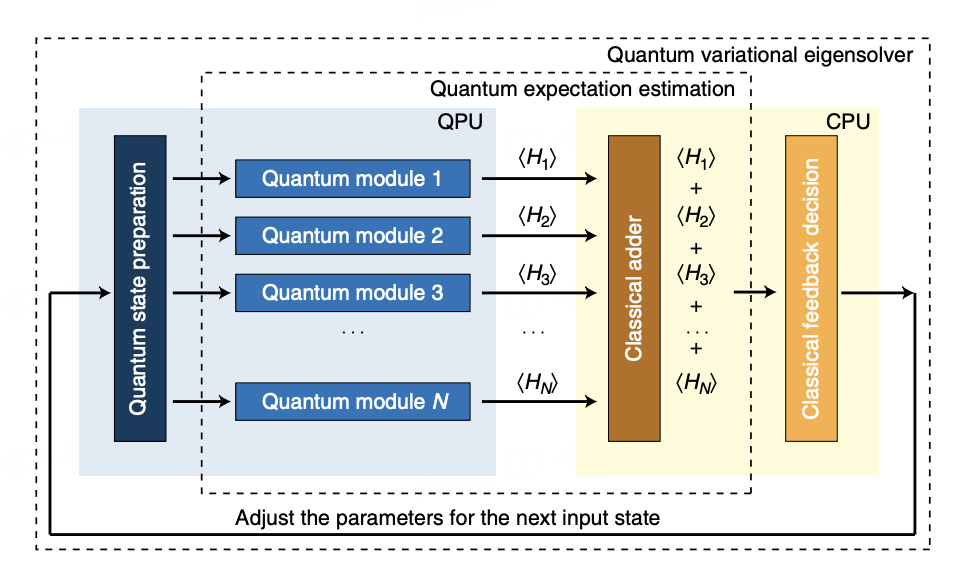

Here we use TenCirChem from Tencent to implement Quantum Chemistry Computation: https://github.com/tencent-quantum-lab/TenCirChem

Taking H_4 molecule for example, UCCSD is a kind of wavefunction ansatz derived form unitary coupled cluster (UCC):

In [1]:
! pip install tencirchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 92.2 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.6 kB/s eta 0:00:00a 0:00:01
     ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/32.6 MB 18.5 kB/s eta 0:26:24^C
     ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/32.6 MB 18.5 kB/s eta 0:26:24
ERROR: Operation cancelled by user


In [29]:
from tencirchem import UCCSD, M

d = 0.8
# distance unit is angstrom
h4 = M(atom=[["H", 0, 0, d * i] for i in range(4)])

# configuration
uccsd = UCCSD(h4)
# calculate and returns energy
uccsd.kernel()
# analyze result
uccsd.print_summary(include_circuit=True)

################################ Ansatz ###############################
 #qubits  #params  #excitations initial condition
       8       11            18               RHF
############################### Circuit ###############################
 #qubits  #gates  #CNOT  #multicontrol  depth  #FLOP
       8     146     98             10     78 506688
############################### Energy ################################
       energy (Hartree)  error (mH) correlation energy (%)
HF            -2.121387   46.173788                 -0.000
MP2           -2.151794   15.766505                 65.854
CCSD          -2.167556    0.004979                 99.989
UCCSD         -2.167546    0.014384                 99.969
FCI           -2.167561    0.000000                100.000
############################# Excitations #############################
      excitation configuration     parameter  initial guess
0         (6, 4)      01100011 -6.291323e-03       0.000000
1         (2, 0)      00110110 -

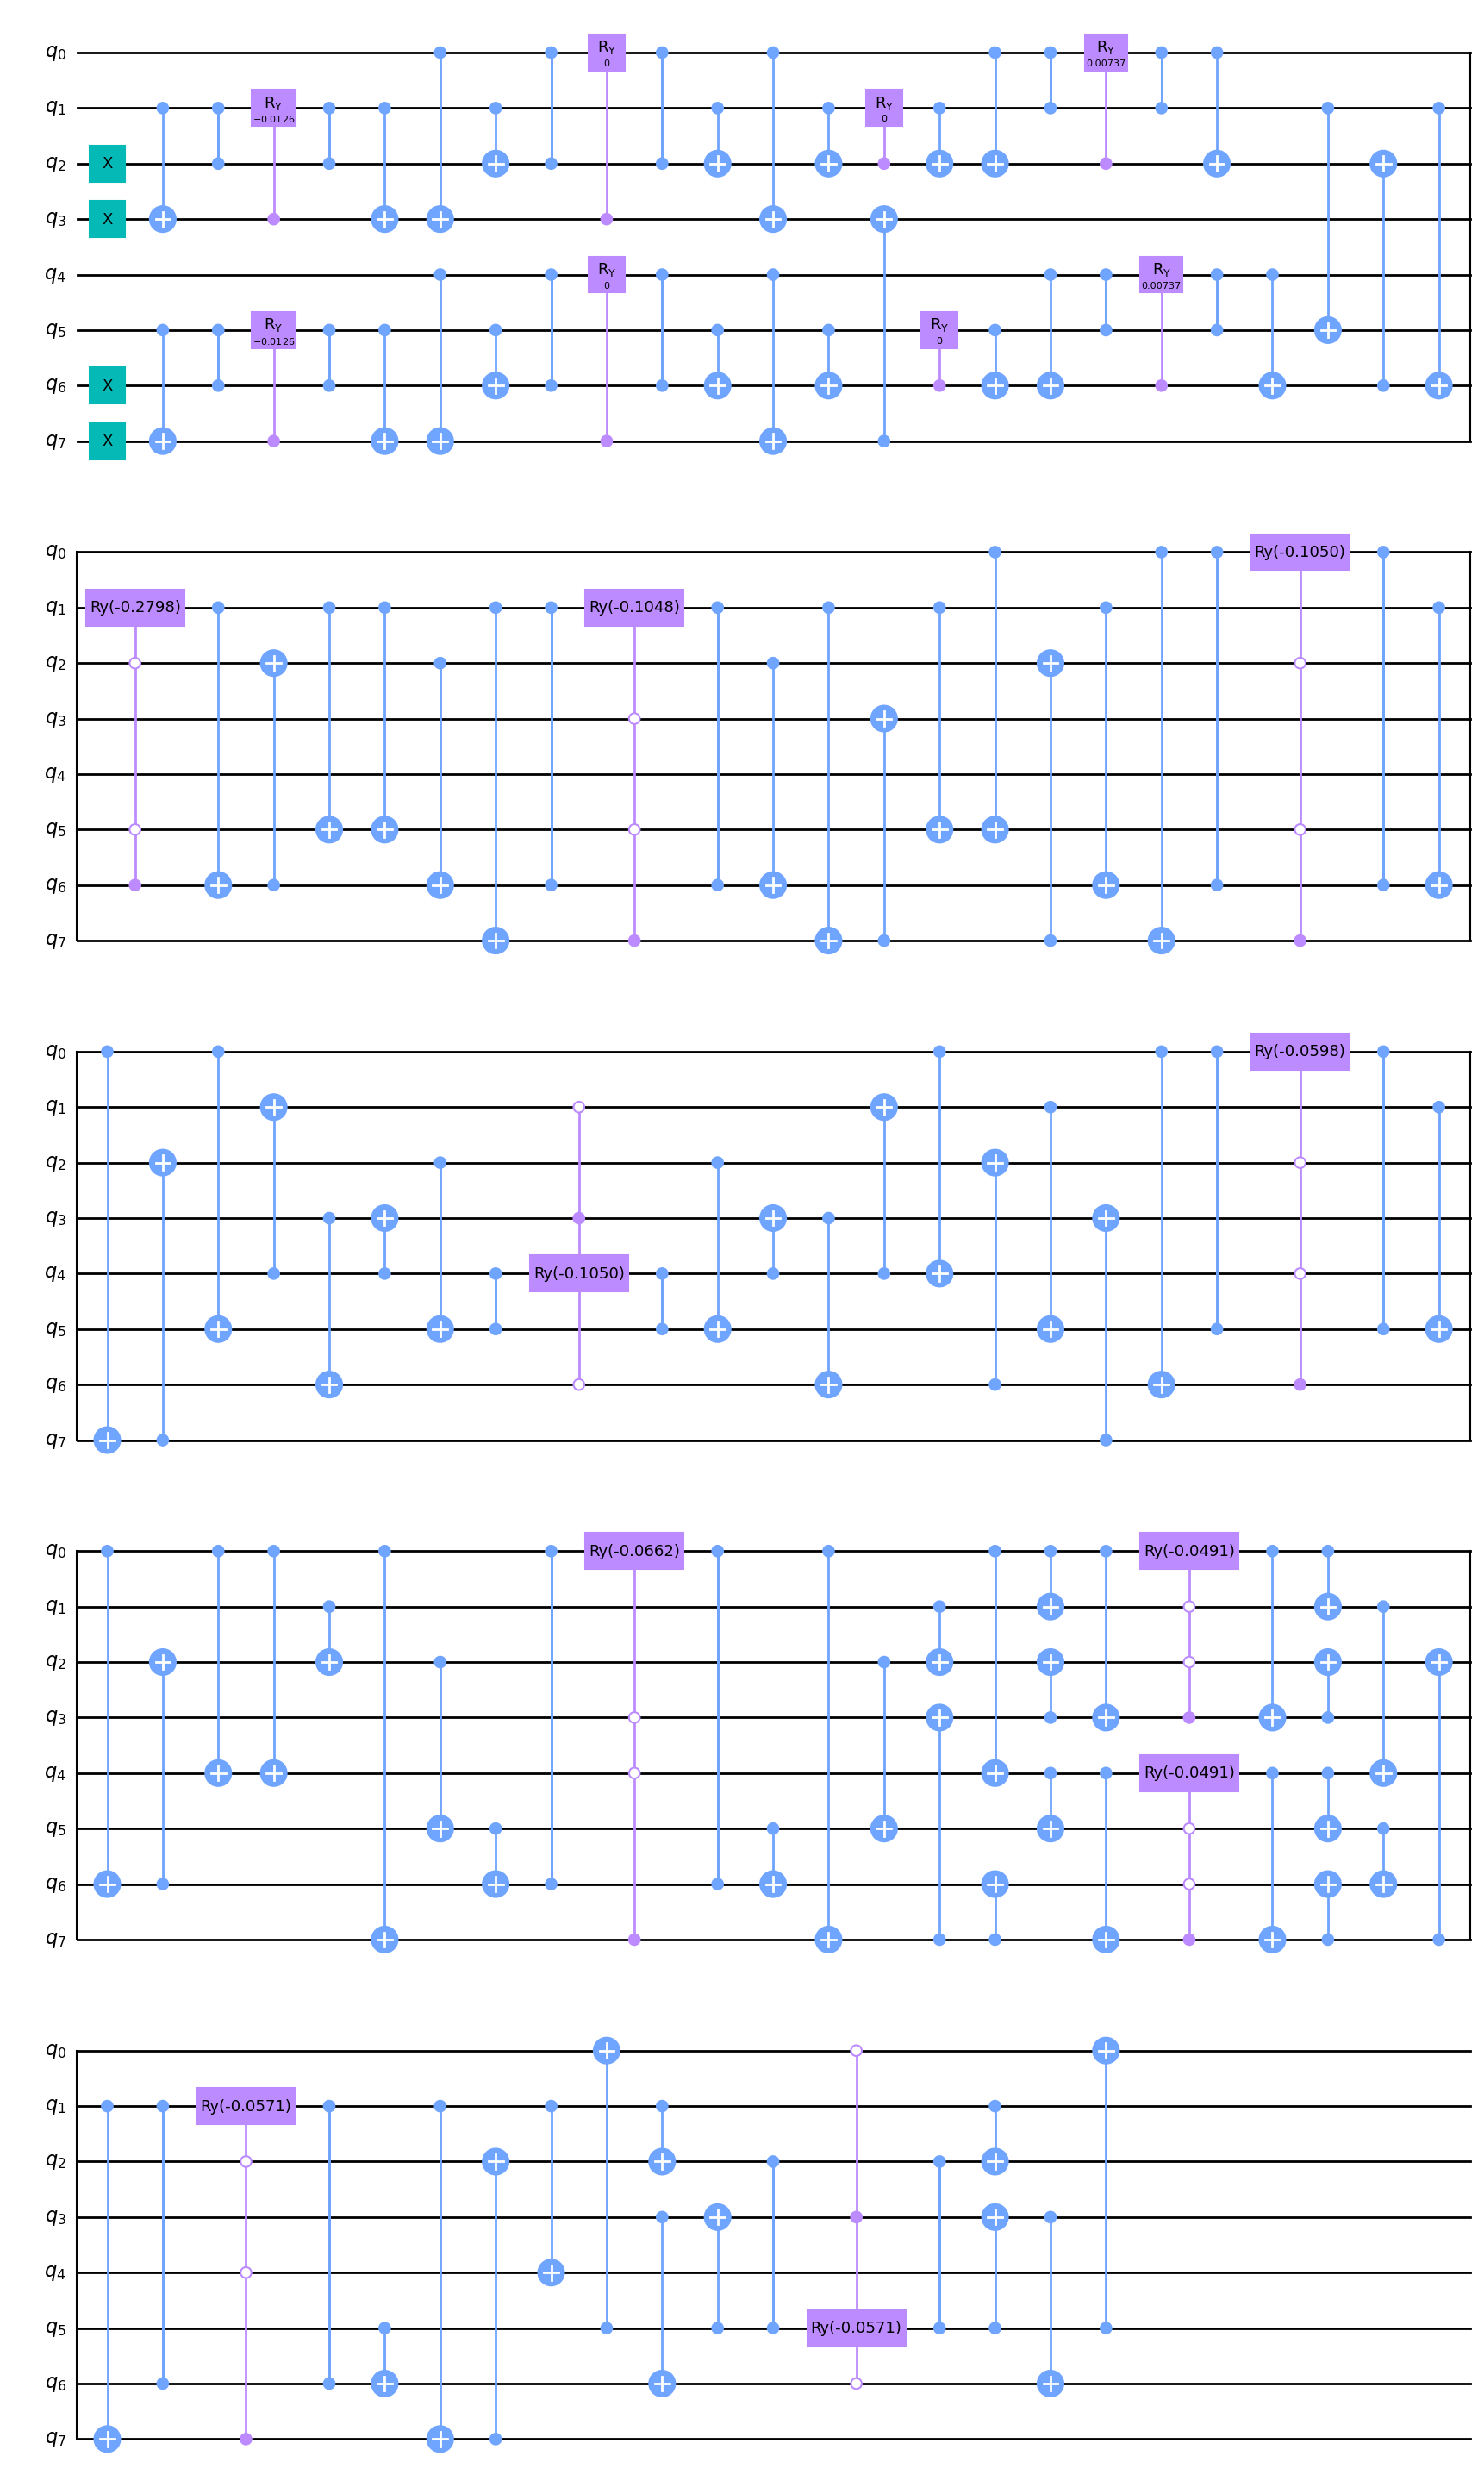

In [30]:
circuit = uccsd.get_circuit()
circuit.draw(output="mpl")

## 3. Reference
1. Richard P. Feynman, *Simulating physics with computers, International Journal of Theoretical Physics* **21** (1982), no. 6, 467-488.
2. Seth Lloyd, *Universal quantum simulators*, Science (1996), 1073-1078.
3. Earl Campbell, Random compiler for fast hamiltonian simulation, Phys. Rev. Lett. **123** (2019), 070503, [1811.08017](https://arxiv.org/abs/1811.08017).
4. Alberto Peruzzo *et al.* *A variational eigenvalue solver on a photonic quantum processor*, Nature communications(2014), 5:4213.


